In [1]:
# basics
import numpy as np
import pandas as pd
from pandas import Timestamp
from sklearn import metrics
from sklearn import linear_model
import pickle

np.__version__, pd.__version__

('1.15.4', '0.23.4')

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:20,.2f}'.format    # format decimal output 
pd.options.display.max_columns = None                   # show all columns in table
pd.options.mode.chained_assignment = None               # default='warn', turn-off this warning

In [7]:
#magics
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
%%R
options(warn=-1)   # do not show warnings: for presentation only

In [10]:
# test
df = pd.DataFrame({
    'cups_of_coffee': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'productivity': [2, 5, 6, 8, 9, 8, 0, 1, 0, -1]
})

/opt/conda/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


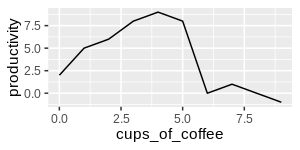

In [11]:
%%R -i df -w 3 -h 1.5 --units in -r 100 

library(ggplot2)
ggplot(df, aes(x=cups_of_coffee, y=productivity)) + geom_line()

# Load

A dataset is a dictionary-like object that holds all the data and some metadata about the data.  Information on the toy and fetched datasets can be found [here](https://scikit-learn.org/stable/datasets/index.html#datasets)
* .data member, which is a 2D array, shape (n_samples, n_features)
* one or more response variables are stored in the .target member

In [53]:
from sklearn import datasets
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
df.shape

(150, 5)

# Explore

In [54]:
df.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.10,3.50,1.40,0.20,0.00
1,4.90,3.00,1.40,0.20,0.00
2,4.70,3.20,1.30,0.20,0.00


In [55]:
indep = iris.data
indep[0:3]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

In [56]:
dep = iris.target
dep[0:3]

array([0, 0, 0])

In [156]:
pd.isnull(df).sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

In [67]:
#balanced dataset
df.target.value_counts()

2.00    50
1.00    50
0.00    50
Name: target, dtype: int64

In [157]:
df.corr(method='pearson')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.00,-0.12,0.87,0.82,0.78
sepal width (cm),-0.12,1.00,-0.43,-0.37,-0.43
petal length (cm),0.87,-0.43,1.00,0.96,0.95
petal width (cm),0.82,-0.37,0.96,1.00,0.96
target,0.78,-0.43,0.95,0.96,1.00


In [159]:
pearson = df.corr(method='pearson')
corr_with_target = pearson.iloc[-1][:-1]
corr_with_target[abs(corr_with_target).argsort()[::-1]]

petal width (cm)                    0.96
petal length (cm)                   0.95
sepal length (cm)                   0.78
sepal width (cm)                   -0.43
Name: target, dtype: float64

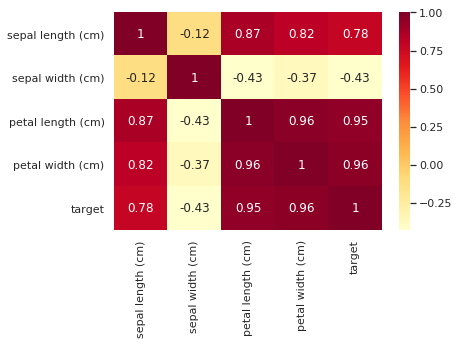

In [174]:
#https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
import seaborn as sns
ax = sns.heatmap(pearson, annot=True, cmap="YlOrRd")

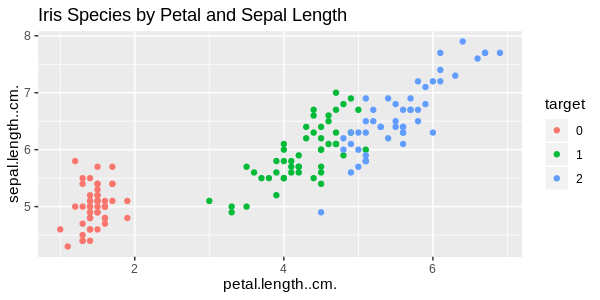

In [66]:
%%R -i df -w 6 -h 3 --units in -r 100 
df$target = factor(df$target)
ggplot(df, aes(x = petal.length..cm., y = sepal.length..cm., colour = target)) + 
  geom_point() + ggtitle('Iris Species by Petal and Sepal Length')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  else:


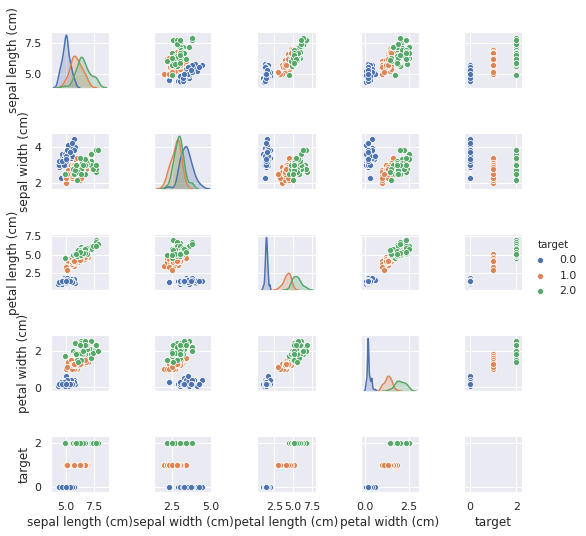

In [183]:
sns.pairplot(df, height=1.5, hue="target")

# Prepare

In [69]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
target = enc.fit_transform(iris.target)

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, target, test_size=0.2)

# Model: sklearn

In [117]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier()
param_grid = {"max_depth": [3, 5, 7]}
tree_gs = GridSearchCV(tree, param_grid, iid=True, cv=5, scoring="accuracy")
tree_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'max_depth': [3, 5, 7]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [104]:
print(tree_gs.best_params_)
#GridSearchCV: Mean cross-validated score of the best_estimator
#SGDClassifier: Returns the mean accuracy on the given test data and labels
print("Best parameter (CV score=%0.3f):" % tree_gs.best_score_)

{'max_depth': 3}
Best parameter (CV score=0.950):


In [105]:
from sklearn.metrics import confusion_matrix
y_test_pred = tree_gs.predict(X_test)
print( "Confusion matrix: Testing")
confusion_matrix(y_test, y_test_pred)

Confusion matrix: Testing


array([[ 7,  0,  0],
       [ 0,  9,  1],
       [ 0,  0, 13]])

In [113]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_test_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         7
  versicolor       1.00      0.90      0.95        10
   virginica       0.93      1.00      0.96        13

   micro avg       0.97      0.97      0.97        30
   macro avg       0.98      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



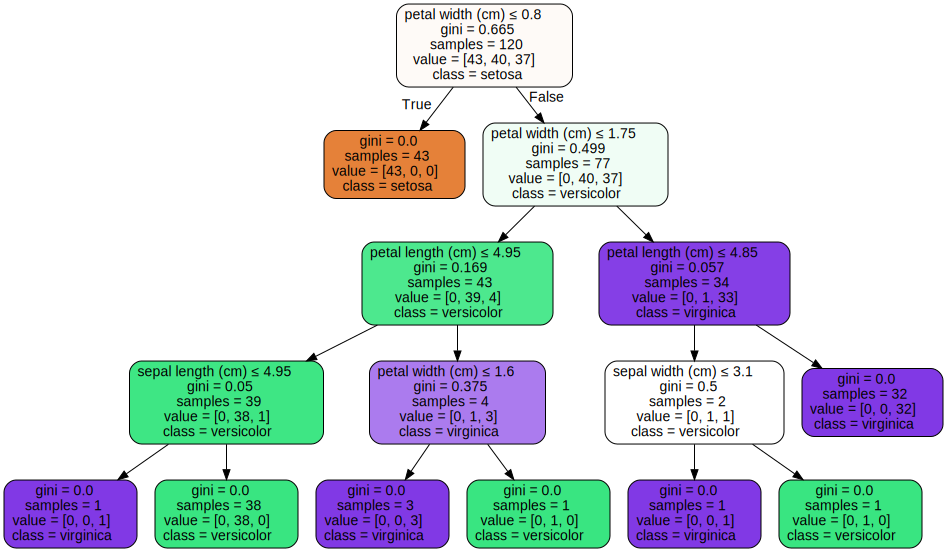

In [131]:
#https://towardsdatascience.com/interactive-visualization-of-decision-trees-with-jupyter-widgets-ca15dd312084
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

graph = Source(sklearn.tree.export_graphviz(tree_gs.best_estimator_
   , out_file=None
   , feature_names=iris.feature_names, class_names=iris.target_names
   , filled=True, rounded=True, special_characters=True))

display(SVG(graph.pipe(format='svg')))

# Model: R Programming

In [185]:
%%R -i df -o fit
#https://stats.stackexchange.com/questions/275652/rpart-cross-validation
library(rpart)
library(caret)

names(df) <- c('sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target')
df$target <- factor(df$target)
head(df)

#split
smp_size <- floor(0.8 * nrow(df))
set.seed(123)
train_ind <- sample(seq_len(nrow(df)), size = smp_size)
train <- df[train_ind, ]
test <- df[-train_ind, ]

#fit
fit <- rpart(target~., data=train)
print("summarize the fit")
summary(fit)

print("make predicions")
predictions <- predict(fit, test[,1:4], type="class")

print("summarize accuracy")
tab <- table(predictions, test$target)
tab

confusionMatrix(tab, mode="everything")

/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)


[1] "summarize the fit"
Call:
rpart(formula = target ~ ., data = train)
  n= 120 

         CP nsplit  rel error    xerror       xstd
1 0.5256410      0 1.00000000 1.0897436 0.06383491
2 0.4102564      1 0.47435897 0.5384615 0.06698641
3 0.0100000      2 0.06410256 0.1025641 0.03503231

Variable importance
 petal_width petal_length sepal_length  sepal_width 
          34           30           21           15 

Node number 1: 120 observations,    complexity param=0.525641
  predicted class=0  expected loss=0.65  P(node) =1
    class counts:    42    41    37
   probabilities: 0.350 0.342 0.308 
  left son=2 (42 obs) right son=3 (78 obs)
  Primary splits:
      petal_length < 2.6  to the left,  improve=40.98590, (0 missing)
      petal_width  < 0.8  to the left,  improve=40.98590, (0 missing)
      sepal_length < 5.45 to the left,  improve=28.63850, (0 missing)
      sepal_width  < 3.15 to the right, improve=17.49012, (0 missing)
  Surrogate splits:
      petal_width  < 0.8  to the left

In [150]:
%%R -i df
# load the package
library(randomForest)

names(df) <- c('sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target')
df$target <- factor(df$target)
head(df)

#split
smp_size <- floor(0.8 * nrow(df))
set.seed(123)
train_ind <- sample(seq_len(nrow(df)), size = smp_size)
train <- df[train_ind, ]
test <- df[-train_ind, ]


# fit model
fit <- randomForest(target~., data=train)
# summarize the fit
summary(fit)

# make predictions
predictions <- predict(fit, test[,1:4])

# summarize accuracy
table(predictions, test$target)

           
predictions  0  1  2
          0  8  0  0
          1  0  9  1
          2  0  0 12
